## Práctica Clasificación Imágenes - Análisis de datos no estructurados

Autores
- Jorge Gómez Berenguer (Github: *jorgegomez94*)
- Raúl Gómez Serrano (Github: *raulgomez05*)

In [1]:
# Se importan las librerías que van a ser necesarias a lo largo de la ejecución
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow
import datetime

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

Se definen los paths para la carpeta de entrenamiento, test, y resultados obtenidos

In [2]:
TRAIN_DIR = '/Alzheimer_s Dataset/train'
TEST_DIR = '/Alzheimer_s Dataset/test'
SAVE_RESULTS_DIR = '/Alzheimer_s Dataset/saved_models'

Se definen las variables, las cuales se pueden modificar para probar distitnas opciones. Dado que optaremos por un modelo ya preentrenado, inicializamos los pesos con los de imagenet 

In [3]:
EPOCHS = 15
WEIGHTS = "imagenet"
image_width = 224
image_height = 224
input_shape = (image_width,image_height,3)

Esta función permite crear una carpeta con la fecha y hora de la ejecución, donde postriormente se guardarán los resultados de la misma.

In [4]:
def create_folder_with_results():
    now = datetime.datetime.now()
    training_time = now.strftime("%Y%m%d_%H%M")
    # Nombre de la carpeta en base a la fecha y hora
    TRAINING_TIME_PATH = SAVE_RESULTS_DIR + "/" + training_time
    try:  
        os.makedirs(TRAINING_TIME_PATH)
        print ("Se ha creado correctamente el directorio %s" % TRAINING_TIME_PATH)
        return TRAINING_TIME_PATH
    except: 
        print ("La creación del directorio %s ha fallado" % TRAINING_TIME_PATH)

Se crea la carpeta de resultados

In [6]:
TRAINING_TIME_PATH = create_folder_with_results()

La creación del directorio C:/Users/jorge/OneDrive/Documentos/01. Máster Big Data/12. Análisis de datos no estructurados/02. Prácticas/03. Alzheimer Classification/Alzheimer_s Dataset/saved_models/20210411_0746 ha fallado


Se define el modelo base, en este caso, se ha optado por el InceptionV3 utilizando la técnica de Transfer Learning

In [7]:
base_model = InceptionV3(input_shape = input_shape, 
                        include_top = False,
                        weights = WEIGHTS)

Se definen los data generators para las imágenes de entrenamiento, validación y test


In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,                      
                                  rotation_range=5,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  #zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

Se define los datasets de entrenamiento, test y validación

In [9]:
train_dataset  = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [10]:
test_dataset = valid_datagen.flow_from_directory(directory = TEST_DIR,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 254 images belonging to 4 classes.


In [15]:
valid_dataset = valid_datagen.flow_from_directory(directory = TEST_DIR,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 254 images belonging to 4 classes.


Congelamos las capas pertenecientes al base model 

In [17]:

for layer in base_model.layers:
    layer.trainable=False

Al base model definido previamente se le añaden nuevas capas que entrenaremos posteriormente

In [18]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

Se genera una archivo de texto que contiene el resumen del modelo generado y se guarda en la carpeta de resultados de la ejecución

In [19]:
with open(TRAINING_TIME_PATH +'/model_summary.txt', 'w') as fh:
        model.summary(print_fn=lambda x: fh.write(x + '\n'))

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
batch_normalization_95 (Batc (None, 64)                2

Se definen las diferentes métricas que van a ser utilizadas para evaluar el modelo

In [20]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

Se crea una función que varía el learning rate 

In [22]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

Se compila el modelo

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = METRICS)

Entrenamiento del modelo

In [24]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks=lr_scheduler)

Epoch 1/15
129/129 [==============================] - 213s 2s/step - loss: 1.1058 - accuracy: 0.7504 - precision: 0.5016 - recall: 0.2618 - auc: 0.7660 - f1_score: 0.3412 - val_loss: 1.1094 - val_accuracy: 0.7618 - val_precision: 0.8750 - val_recall: 0.0551 - val_auc: 0.7804 - val_f1_score: 0.1022
Epoch 2/15
129/129 [==============================] - 210s 2s/step - loss: 1.0034 - accuracy: 0.7737 - precision: 0.6135 - recall: 0.2560 - auc: 0.8029 - f1_score: 0.3584 - val_loss: 1.0829 - val_accuracy: 0.7638 - val_precision: 1.0000 - val_recall: 0.0551 - val_auc: 0.7580 - val_f1_score: 0.1021
Epoch 3/15
129/129 [==============================] - 233s 2s/step - loss: 0.9721 - accuracy: 0.7867 - precision: 0.6838 - recall: 0.2728 - auc: 0.8141 - f1_score: 0.3861 - val_loss: 1.0307 - val_accuracy: 0.7726 - val_precision: 0.8710 - val_recall: 0.1063 - val_auc: 0.7995 - val_f1_score: 0.1858
Epoch 4/15
129/129 [==============================] - 215s 2s/step - loss: 0.9636 - accuracy: 0.7897 - 

Se define la función que permite visualizar gráficos con los resultados obtenidos

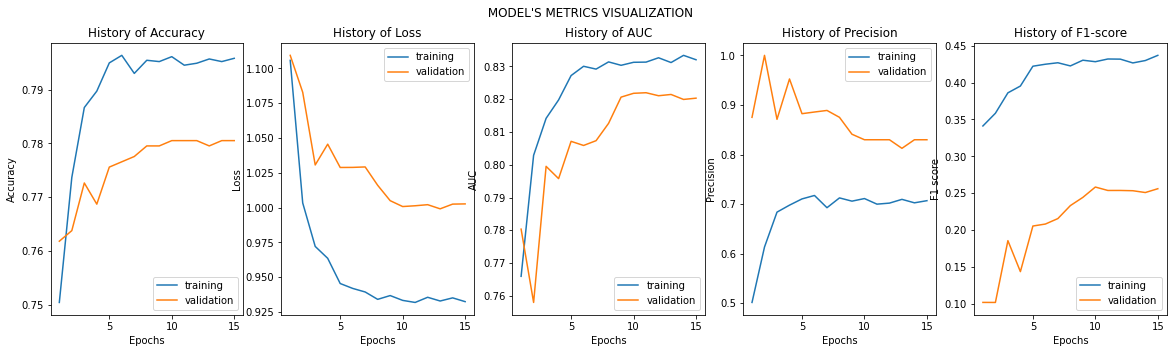

In [25]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
# Se llama a la función definida anteriormente para generar los gráficos en base al resultado obtenido en la ejecución
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

- De manera generalizada, todas las variables para training y test parecen estabilizarse en las 10 EPOCHS, por lo que no sería necesario realizar un número de iteraciones muy superior al que actualmente estamos realizando. 
- Lo más destacable en este modelo podría ser la variable Precision para el dataset de test, comienza en valores cercanos a 1, muy probablemente fruto del azar, y a medida que aumentan las EPOCHS tiende a 0,8 

Se obtienen los resultados

In [26]:
scores = model.evaluate_generator(test_dataset)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Se muestran por pantalla los resultados

In [27]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7805117964744568
Precision =  0.8297872543334961
Recall =  0.15354330837726593
AUC =  0.8203004002571106
F1_score =  0.2555168867111206


Se genera un archivo de texto que guarde todos los resultados de la ejecución en la carpeta de resultados

In [31]:
with open(TRAINING_TIME_PATH +'/history.txt', 'w') as f:  
        f.write(str(history.history))

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'